In [95]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

In [96]:
import keras.backend as K
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [97]:
seed = 232
np.random.seed(seed)           # Sets the seed for NumPy's random number generator.
tf.random.set_seed(seed)       # Sets the seed for TensorFlow's random number generator.


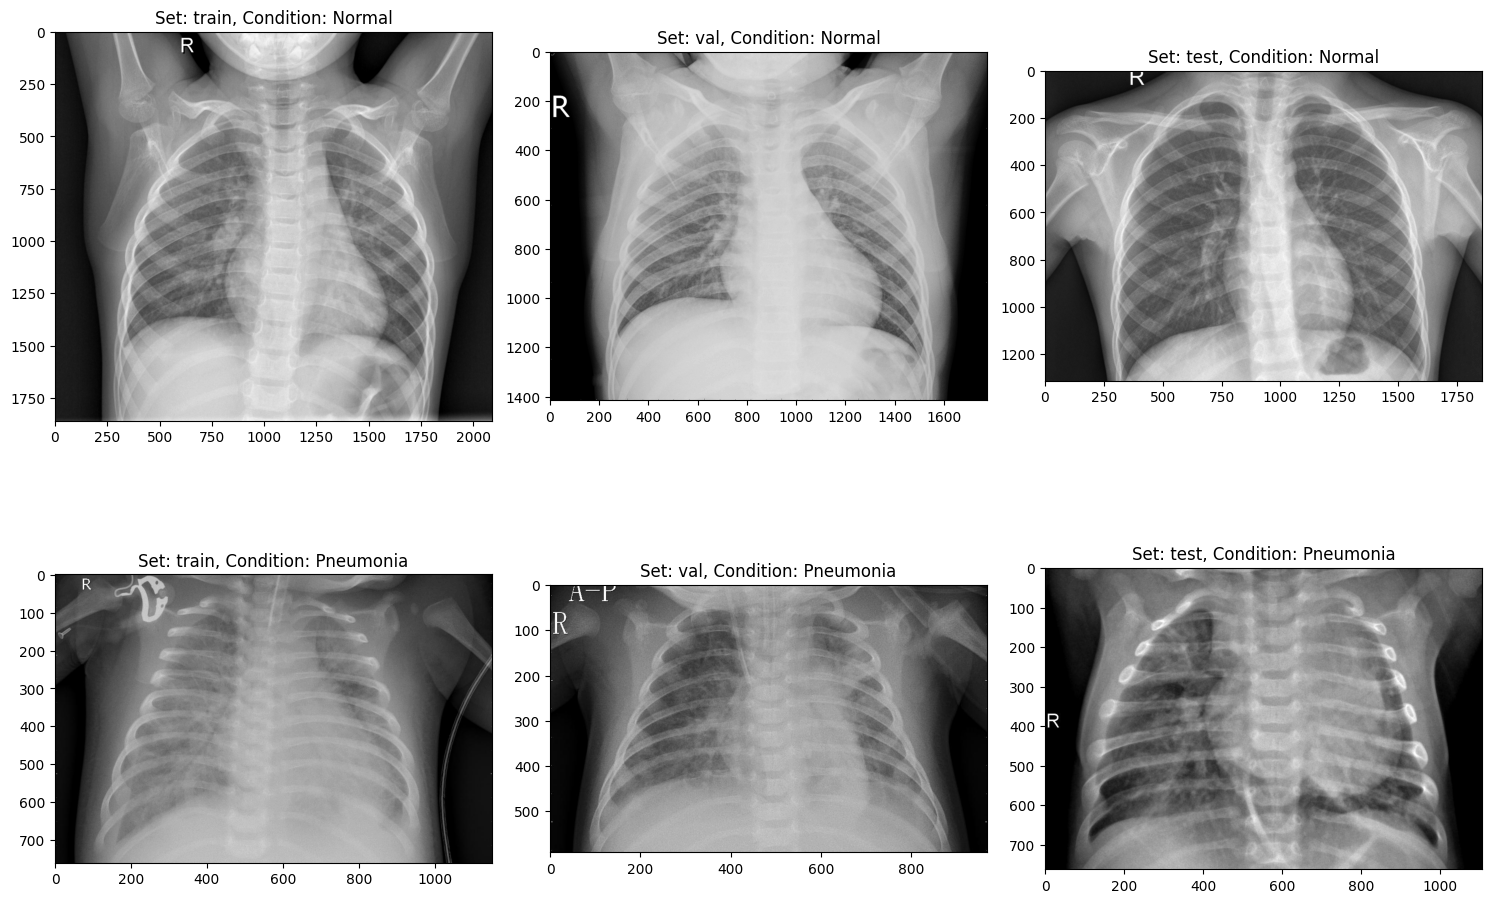

In [98]:
# Define the base path to the dataset
path = './dataset/chest_xray/'

# Create a 2x3 grid for subplots to visualize images
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()  # Flatten the array of axes for easy indexing
plt.tight_layout()  # Automatically adjust subplot parameters for better layout

# Loop through the dataset splits: train, val, and test
for i, _set in enumerate(['train', 'val', 'test']):
    # Construct the path to the current dataset split
    set_path = os.path.join(path, _set)

    # Display a sample image from the NORMAL category
    normal_image_path = os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])
    ax[i].imshow(plt.imread(normal_image_path), cmap='gray')  # Read and display the image
    ax[i].set_title(f'Set: {_set}, Condition: Normal')  # Set the title indicating dataset split and condition

    # Display a sample image from the PNEUMONIA category
    pneumonia_image_path = os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])
    ax[i + 3].imshow(plt.imread(pneumonia_image_path), cmap='gray')  # Read and display the image
    ax[i + 3].set_title(f'Set: {_set}, Condition: Pneumonia')  # Set the title indicating dataset split and condition

# Show the plotted images
plt.show()


In [99]:
def process_data(img_dims, batch_size):
    # Data generation objects
    # Create an ImageDataGenerator for training data with augmentations
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,  # Normalize pixel values to range [0, 1]
        shear_range=0.2,  # Apply random shear transformations to augment data
        zoom_range=0.2,  # Apply random zoom to augment data
        horizontal_flip=True  # Randomly flip images horizontally to augment data
    )

    # Create an ImageDataGenerator for test/validation data without augmentations
    test_val_datagen = ImageDataGenerator(
        rescale=1.0 / 255  # Normalize pixel values to range [0, 1]
    )

    # Training data generator
    # Reads images from the training directory, applies augmentations, and prepares batches
  
    train_gen = train_datagen.flow_from_directory(
        directory='./dataset/chest_xray/train',  
        target_size=(img_dims, img_dims),  # Resize images to the specified dimensions
        batch_size=batch_size, # Number of images per batch
        class_mode='binary', # Binary classification: NORMAL vs PNEUMONIA
        shuffle=True # Shuffle the data for better generalization
    )

    # Test data generator
    # Reads images from the test directory and prepares batches without augmentations
    test_gen = test_val_datagen.flow_from_directory(
        directory='./dataset/chest_xray/test',
        target_size=(img_dims, img_dims),  # Resize images to the specified dimensions
        batch_size=batch_size,  # Number of images per batch
        class_mode='binary',  # Binary classification: NORMAL vs PNEUMONIA
        shuffle=False  # Do not shuffle test data to preserve order
    )

    # Validation data generator
    # Reads images from the validation directory and prepares batches without augmentations
    val_gen = test_val_datagen.flow_from_directory(
        directory='./dataset/chest_xray/val',
        target_size=(img_dims, img_dims),  # Resize images to the specified dimensions
        batch_size=batch_size,  # Number of images per batch
        class_mode='binary',  # Binary classification: NORMAL vs PNEUMONIA
        shuffle=True  # Shuffle the data for better generalization
    )

    # Create test_data and test_labels arrays manually from the test directory
    test_data, test_labels = [], []
    for condition in ['/NORMAL/', '/PNEUMONIA/']:
        path = './dataset/chest_xray/test' + condition  # Path to test images
        for img_name in os.listdir(path):
            img = plt.imread(os.path.join(path, img_name))  # Read the image
            img = cv2.resize(img, (img_dims, img_dims))  # Resize image to the specified dimensions
            img = img.astype('float32') / 255.0  # Normalize pixel values to range [0, 1]
            # Ensure the image has 3 channels (RGB) for consistency
            img = np.expand_dims(img, axis=-1) if len(img.shape) == 2 else img
            test_data.append(img)  # Add the processed image to the test data list
            test_labels.append(0 if condition == '/NORMAL/' else 1)  # Assign label: 0 for NORMAL, 1 for PNEUMONIA

    test_data = np.array(test_data)  # Convert test data list to NumPy array
    test_labels = np.array(test_labels)  # Convert test labels list to NumPy array

    return train_gen, test_gen, val_gen, test_data, test_labels


In [131]:
def process_data(img_dims, batch_size):
    """
    Function to preprocess data for training, testing, and validation.

    Args:
        img_dims (int): Dimensions to which the images will be resized.
        batch_size (int): Number of samples per batch.

    Returns:
        train_gen: Data generator for training data.
        test_gen: Data generator for test data.
        test_data: Array of test images.
        test_labels: Array of test labels.
    """
    
    # Path to dataset
    path = './dataset/chest_xray/'

    # Data generation objects
    # Data augmentation for training images
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
        shear_range=0.2,  # Random shear transformations
        zoom_range=0.2,  # Random zoom transformations
        horizontal_flip=True  # Random horizontal flipping
    )
    
    # No data augmentation for validation and test images, only normalization
    test_val_datagen = ImageDataGenerator(
        rescale=1.0 / 255
    )
    
    # Training data generator
    train_gen = train_datagen.flow_from_directory(
        directory=path + 'train',
        target_size=(img_dims, img_dims),  # Resize images to specified dimensions
        batch_size=batch_size,  # Number of images per batch
        class_mode='binary',  # Binary classification (NORMAL vs PNEUMONIA)
        shuffle=True  # Shuffle training data
    )
    
    # Test data generator
    test_gen = test_val_datagen.flow_from_directory(
        directory=path + 'test',
        target_size=(img_dims, img_dims),  # Resize images
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True  # Shuffle test data
    )
    
    # Validation data generator
    val_gen = test_val_datagen.flow_from_directory(
        directory=path + 'val',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    # Prepare test data and labels manually
    test_data = []
    test_labels = []
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        condition_path = path + 'test' + cond
        for img_name in os.listdir(condition_path):
            # Load the image
            img = plt.imread(condition_path + img_name)
            # Resize the image to the required dimensions
            img = cv2.resize(img, (img_dims, img_dims))
            # Ensure the image has three channels (RGB)
            img = np.dstack([img, img, img])
            # Normalize pixel values to [0, 1]
            img = img.astype('float32') / 255.0
            # Assign labels: 0 for NORMAL, 1 for PNEUMONIA
            label = 0 if cond == '/NORMAL/' else 1
            # Append to the test data and labels
            test_data.append(img)
            test_labels.append(label)
    
    # Convert test data and labels to NumPy arrays
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, val_gen, test_data, test_labels


In [100]:
import os

# Define training dataset path
train_path = './dataset/chest_xray/train'

# Count the number of images in each class
class_counts = {}
for label in ['NORMAL', 'PNEUMONIA']:
    class_counts[label] = len(os.listdir(os.path.join(train_path, label)))

# Display the class counts
print("Class Distribution in Training Set:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Class Distribution in Training Set:
NORMAL: 1341
PNEUMONIA: 3875


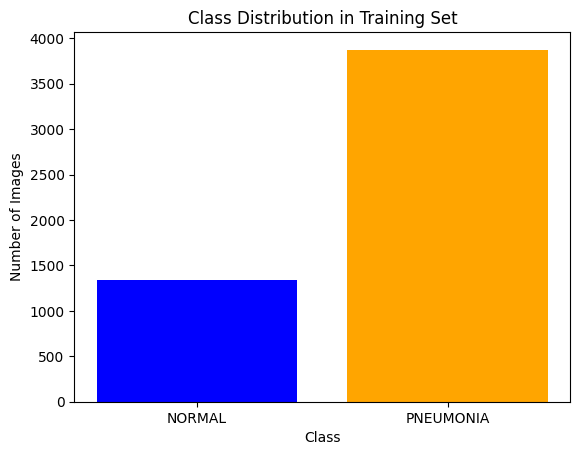

In [101]:
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [132]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [103]:
batch = next(iter(train_gen))
print(type(batch), len(batch))  # Should print something like: <class 'tuple'> 2
print(batch[0].shape)  # Shape of features, e.g., (32, 150, 150, 1)
print(batch[1].shape)  # Shape of labels, e.g., (32,)

<class 'tuple'> 2
(32, 150, 150, 3)
(32,)


In [104]:
from sklearn.utils.class_weight import compute_class_weight

# Extract class labels and counts from training generator
class_labels = train_gen.classes  # Get classes from the generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights_dict = dict(enumerate(class_weights))

In [105]:
print(class_weights_dict)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [133]:
# CNN Architecture
inputs = Input(shape=(img_dims, img_dims, 3))  # Input layer for 150x150 RGB images

# First convolutional block
# Extracts low-level features with two convolutional layers and reduces spatial dimensions
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)  # Down-sampling

# Second convolutional block
# Adds more filters for higher-level features and includes batch normalization
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)  # Normalize activations
x = MaxPool2D(pool_size=(2, 2))(x)

# Third convolutional block
# Further increases feature extraction capability with additional filters
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth convolutional block
# Extracts even higher-level features and adds dropout for regularization
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth convolutional block
# Extracts the most abstract features and includes dropout for regularization
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully connected layers
# Flatten feature maps into a single vector and apply dense layers with dropout
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)  # High dropout for regularization
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
# Single neuron with sigmoid activation for binary classification
output = Dense(units=1, activation='sigmoid')(x)

# Creating the model
model = Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for training
checkpoint = ModelCheckpoint(
    filepath='best_weights.weights.h5',  # Ensure the file extension is `.weights.h5`
    save_best_only=True,
    save_weights_only=True
)
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=2,
    mode='max'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=1,
    mode='min'
)

In [134]:
hist = model.fit(
            train_gen,
            steps_per_epoch=train_gen.samples // batch_size, 
            epochs=20,
            validation_data=test_gen, 
            validation_steps=test_gen.samples // batch_size,
            class_weight=class_weights_dict,
            callbacks=[checkpoint, lr_reduce])

C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 701ms/step - accuracy: 0.7907 - loss: 0.4350 - val_accuracy: 0.6217 - val_loss: 0.7750 - learning_rate: 0.0010
Epoch 2/20


C:\Users\bikas\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9001 - loss: 0.2533
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 750ms/step - accuracy: 0.9001 - loss: 0.2533 - val_accuracy: 0.6266 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.7046 - learning_rate: 3.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9261 - loss: 0.2066
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 715ms/step - accuracy: 0.9261 - loss: 0.2065 - val_accuracy: 0.6234 - val_loss: 0.7654 - learning_rate: 3.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

In [139]:
import pickle
# Save the training history into a pickle file
# 'hist.history' contains loss and accuracy for each epoch
with open('pickle_files/cnn_model.pkl', 'wb') as f:
    pickle.dump(hist.history, f)


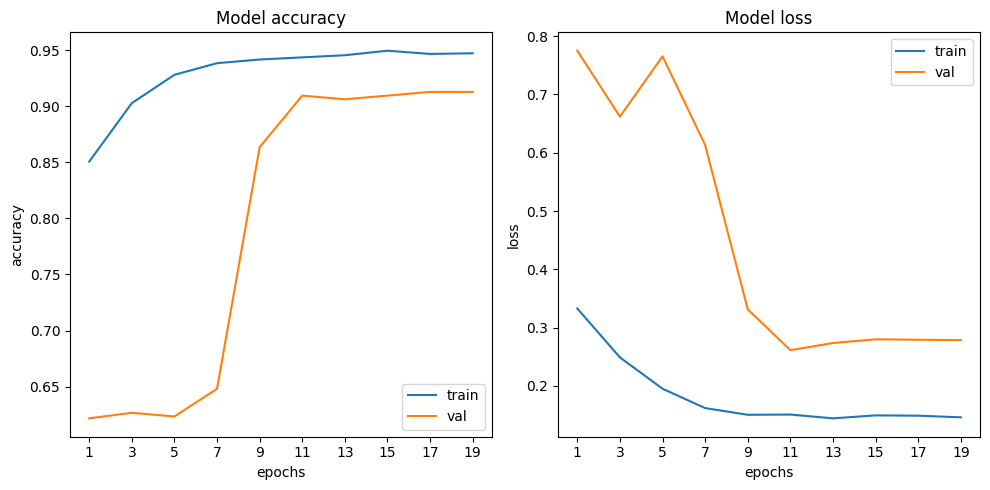

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

# Get total epochs and filter out epochs with zero training time
epochs = range(1, len(hist.history['accuracy']) + 1)
valid_epochs = [e for e, acc in enumerate(hist.history['accuracy'], start=1) if acc > 0]

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(valid_epochs, [hist.history[met][e - 1] for e in valid_epochs], label='train')
    ax[i].plot(valid_epochs, [hist.history['val_' + met][e - 1] for e in valid_epochs], label='val')
    
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    
    # Set x-ticks to valid epochs only
    ax[i].set_xticks(valid_epochs)
    ax[i].legend()

plt.tight_layout()
plt.show()


In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Generate predictions for the test dataset
preds = model.predict(test_data)
preds_rounded = np.round(preds)  # Convert probabilities to binary classes (0 or 1)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, preds_rounded) * 100
precision = precision_score(test_labels, preds_rounded) * 100
recall = recall_score(test_labels, preds_rounded) * 100
f1 = f1_score(test_labels, preds_rounded)
cm = confusion_matrix(test_labels, preds_rounded)

# Display evaluation metrics
print("EVALUATION METRICS:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}")

print("\nCONFUSION MATRIX:")
print(cm)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
EVALUATION METRICS:
Accuracy: 91.19%
Precision: 89.04%
Recall: 97.95%
F1-Score: 0.93

CONFUSION MATRIX:
[[187  47]
 [  8 382]]


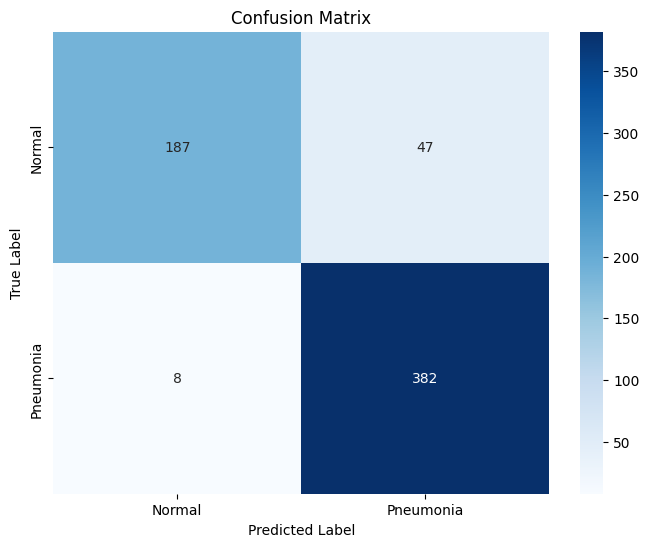

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(test_labels, np.round(preds))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


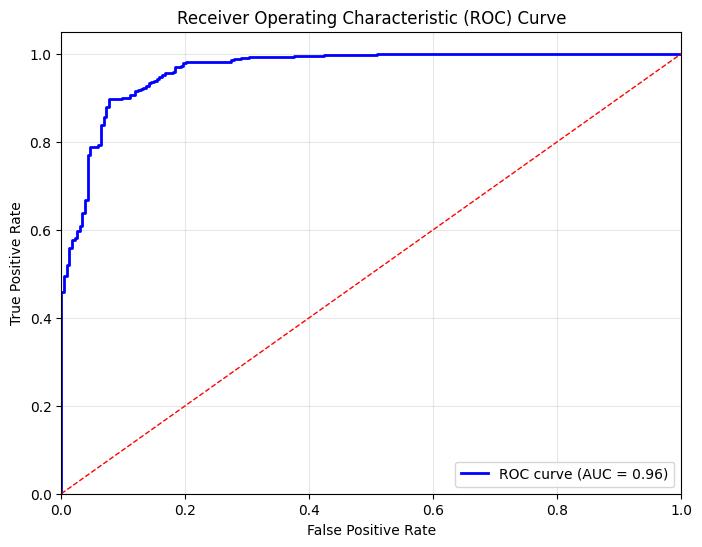

In [142]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1)  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


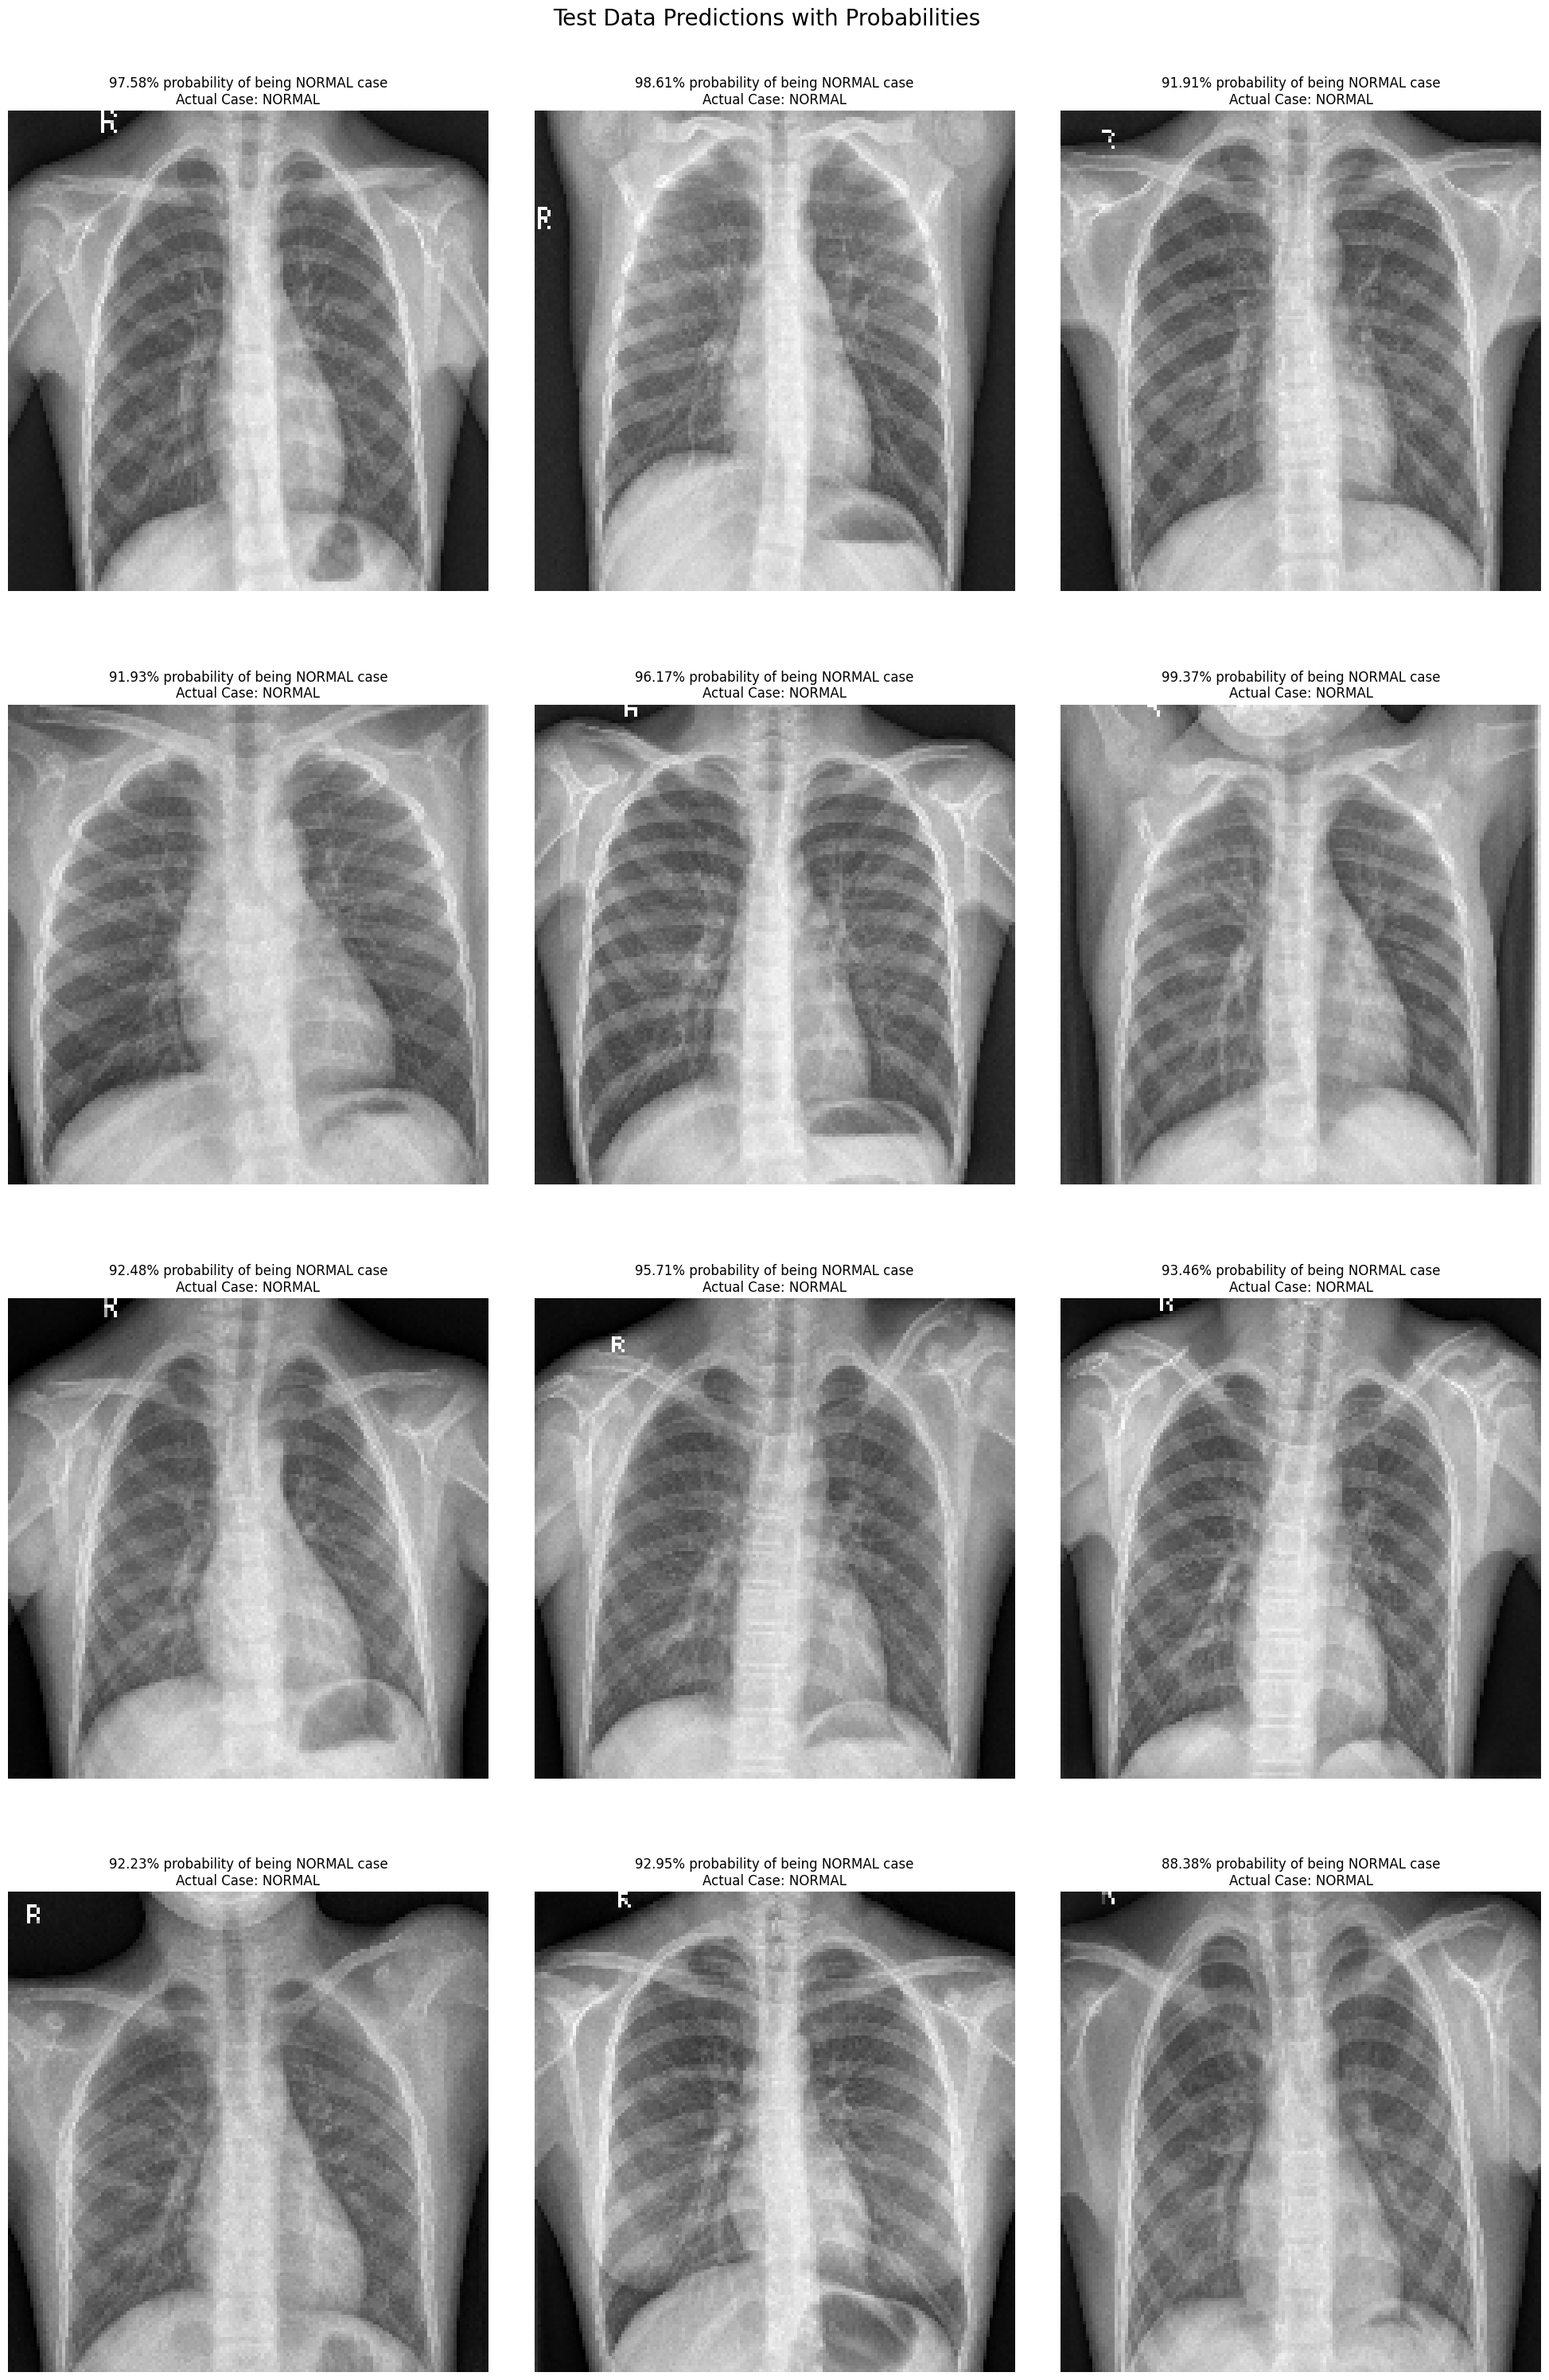

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of subplots to visualize the images, their predictions, and actual labels
fig, ax = plt.subplots(4, 3, figsize=(20, 30))  # 4 rows and 3 columns of subplots
ax = ax.ravel()  # Flatten the axes array for easy indexing
plt.tight_layout()  # Adjust layout to prevent overlap between subplots

# Iterate through the first 12 images in the test dataset
for i in range(12):
    ax[i].imshow(test_data[i])  # Display the image

    # Generate the prediction probability for the image
    predicted_probability = preds[i][0]  # Convert the prediction to a scalar value

    # Check the actual label to determine the true class
    actual_label = test_labels[i]  # Actual label: 0 (Normal) or 1 (Pneumonia)

    # Customize the title based on the prediction and actual label
    if actual_label == 0:  # If the actual label is Normal
        ax[i].set_title(
            '{:.2f}% probability of being NORMAL case'.format((1 - predicted_probability) * 100) +
            '\n' + 'Actual Case: NORMAL',
            fontsize=12
        )
    else:  # If the actual label is Pneumonia
        ax[i].set_title(
            '{:.2f}% probability of being PNEUMONIA case'.format(predicted_probability * 100) +
            '\n' + 'Actual Case: PNEUMONIA',
            fontsize=12
        )

    ax[i].axis('off')  # Turn off axis for better visualization

# Add a common title for the entire plot
plt.suptitle('Test Data Predictions with Probabilities', fontsize=20, y=1.02)

# Show the plot
plt.show()


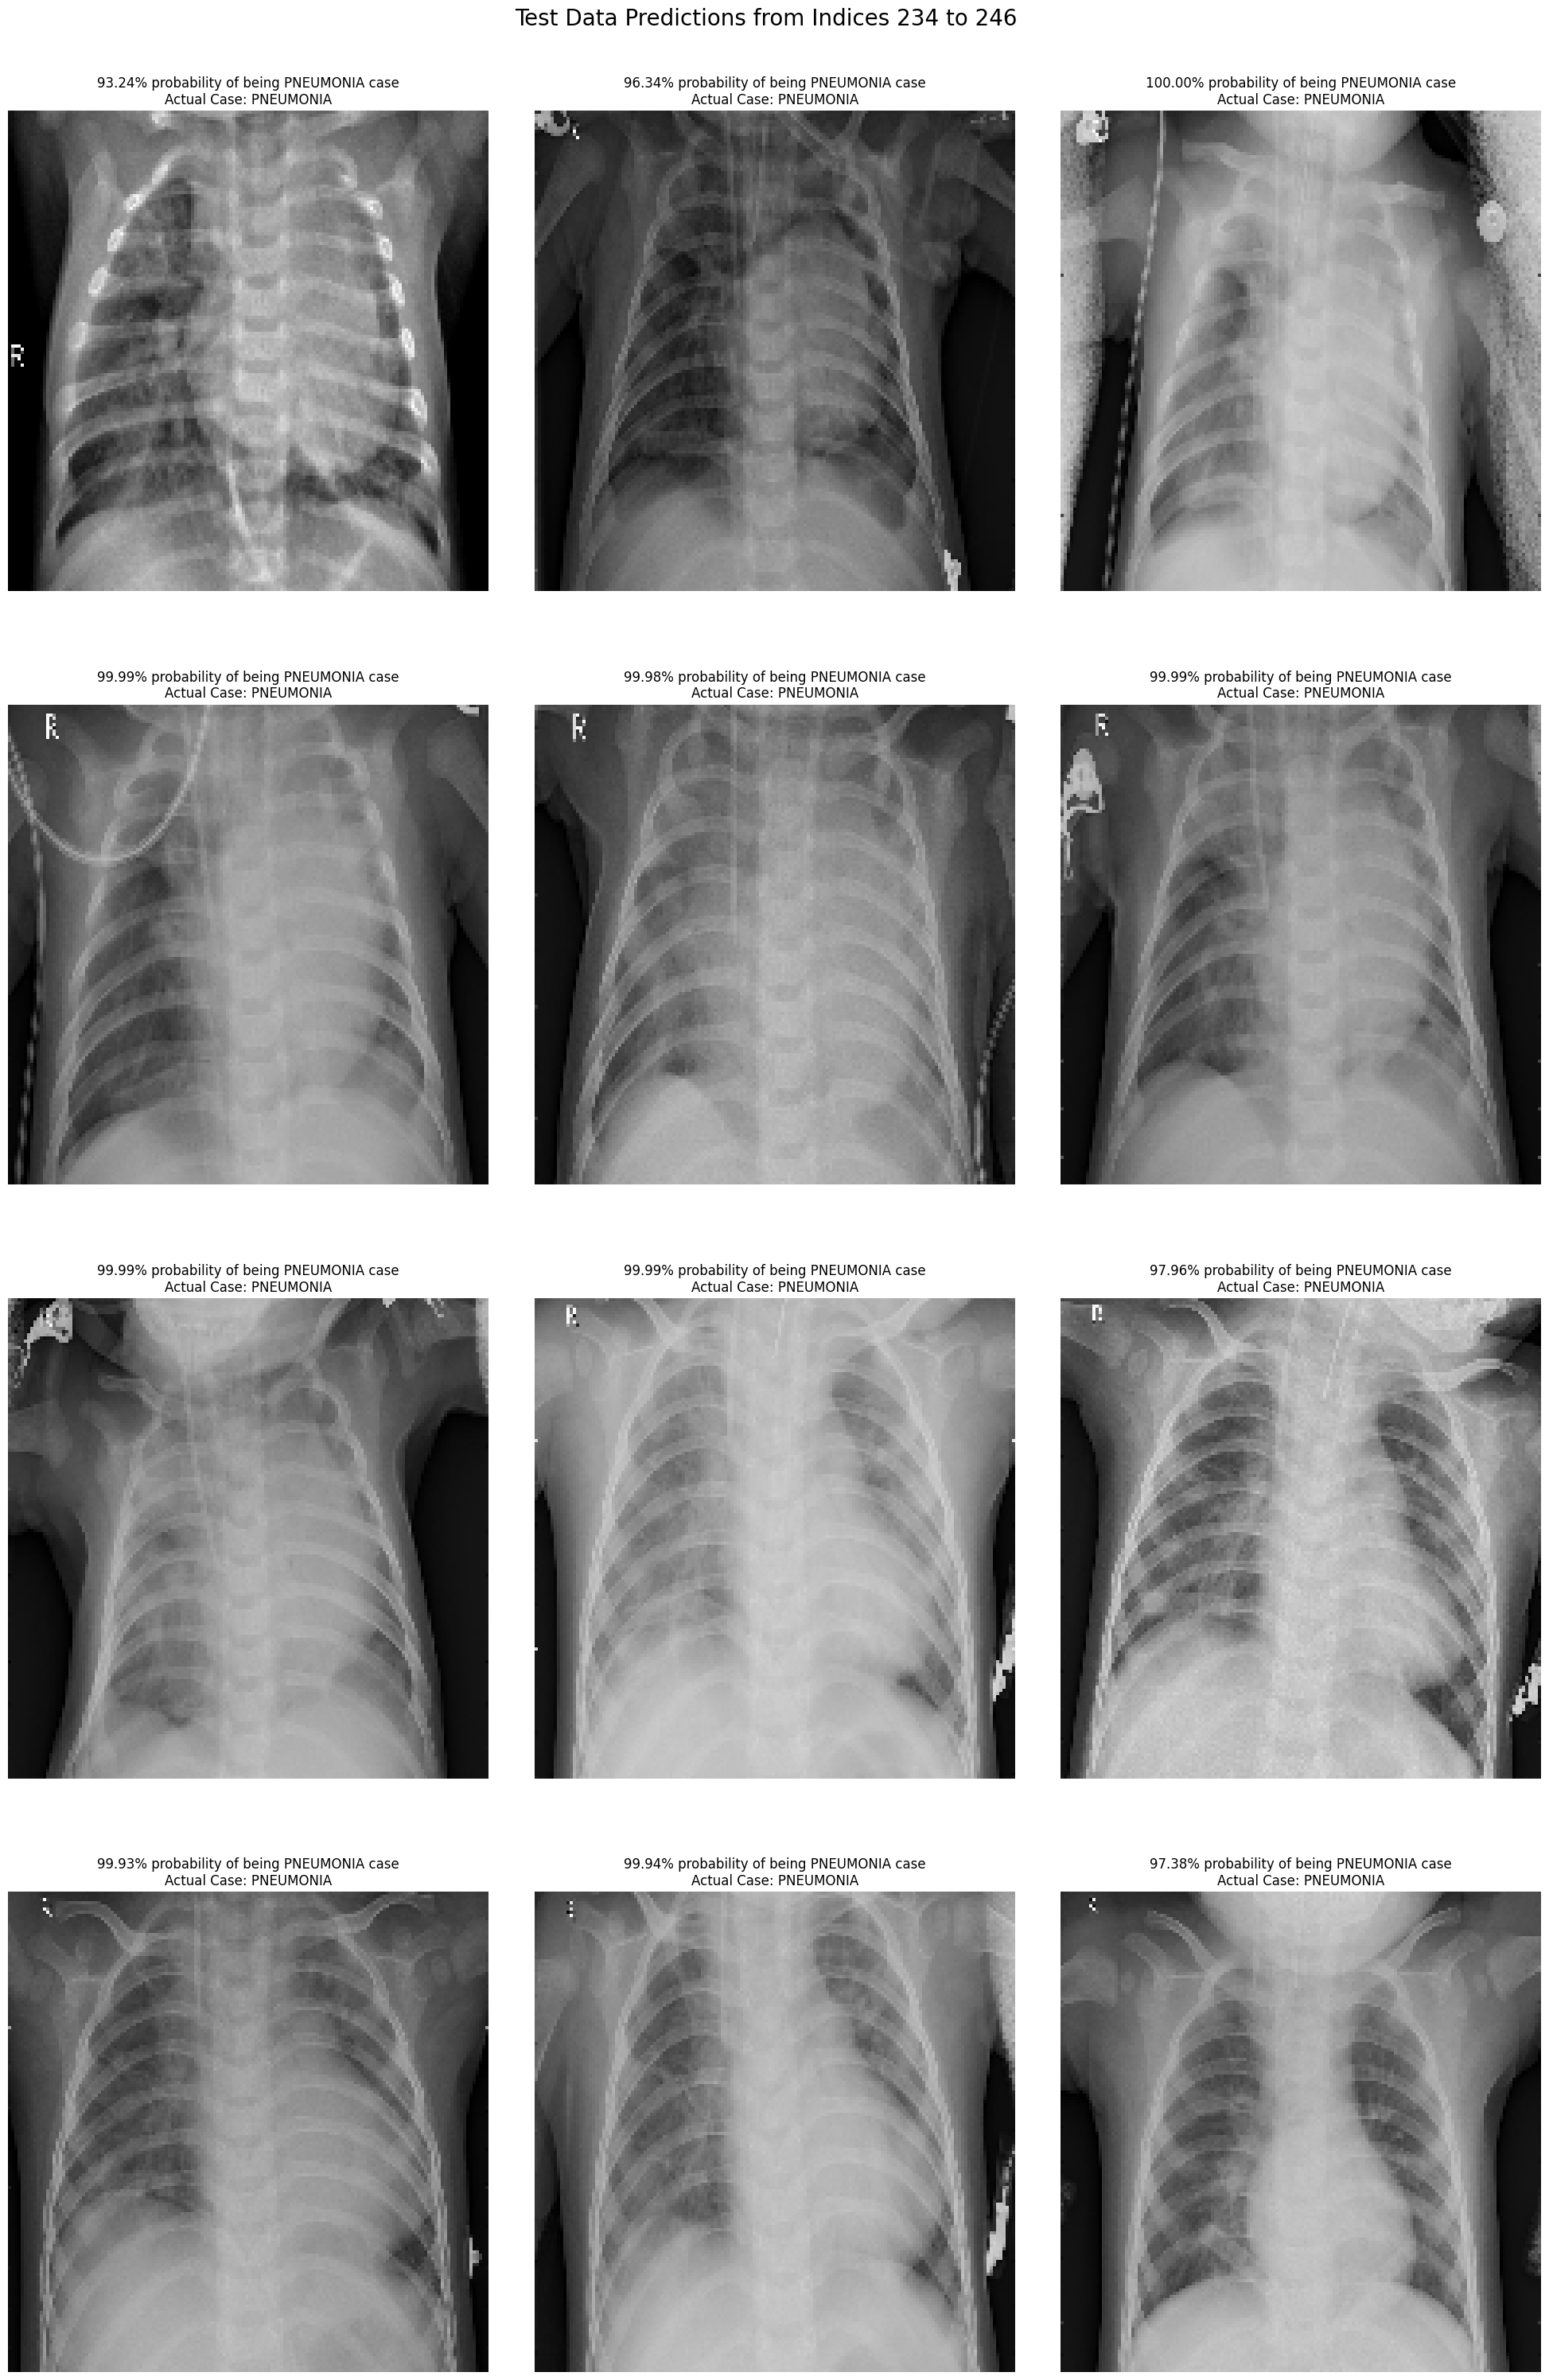

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Number of rows and columns in the grid
rows, cols = 4, 3

# Create a grid of subplots to visualize the images, their predictions, and actual labels
fig, ax = plt.subplots(rows, cols, figsize=(20, 30))  # Create subplots grid
ax = ax.ravel()  # Flatten the axes array for easy indexing
plt.tight_layout()  # Adjust layout to prevent overlap between subplots

# Start index for images to display
start_index = 234

# Iterate through 12 images from the specified range
for i in range(12):
    idx = start_index + i  # Calculate the index of the current image

    # Display the image in the subplot
    ax[i].imshow(test_data[idx])  # Show the image from test_data

    # Generate the prediction probability for the image
    predicted_probability = preds[idx][0]  # Access the scalar value for prediction

    # Check the actual label to determine the true class
    actual_label = test_labels[idx]  # Actual label: 0 (Normal) or 1 (Pneumonia)

    # Customize the title based on the prediction and actual label
    if actual_label == 0:  # If the actual label is Normal
        ax[i].set_title(
            '{:.2f}% probability of being NORMAL case'.format((1 - predicted_probability) * 100) +
            '\n' + 'Actual Case: NORMAL',
            fontsize=12
        )
    else:  # If the actual label is Pneumonia
        ax[i].set_title(
            '{:.2f}% probability of being PNEUMONIA case'.format(predicted_probability * 100) +
            '\n' + 'Actual Case: PNEUMONIA',
            fontsize=12
        )

    ax[i].axis('off')  # Turn off axis for better visualization

# Add a common title for the entire plot
plt.suptitle('Test Data Predictions from Indices 234 to 246', fontsize=20, y=1.02)

# Show the plot
plt.show()
